# 实验一　全连接神经网络 

<br>


## 实验说明
<br>

　　<font color=black size=3 face=雅黑> 使用像 TensorFlow 和 PyTorch 这样的高级框架（deep learning framework），能够让我们方便、快速地构建各类神经网络模型。然而，理解神经网络的基本概念和内部原理对初学者来说同样重要。在本次实验中，我们将学习如何使用 Numpy 实现一个简单的全连接神经网络，并利用它来处理一个简单的分类任务，通过实践来加深对神经网络内部机制的理解。

　　<font color=black size=3 face=雅黑> 本次实验中我们将主要使用如下两个 Python 库：
        
　　　　<font color=black size=3 face=雅黑> - Numpy (Python 科学计算库，用于实现全连接神经网络)
   
　　　　<font color=black size=3 face=雅黑> - Pytorch (深度学习框架，本次实验中我们将练习用它读取数据集 MNIST)
        
<code>
%%html
<img src ="https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fwww.wazhi.com.cn%2Fschool%2Fimage%2F1169%2F20200728%2F20200728051325463.jpg&refer=http%3A%2F%2Fwww.wazhi.com.cn&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1635389536&t=97e1d309d9c32fe9a4a1b934f033b45f", width=20%>
<img src ="https://img1.baidu.com/it/u=2422714346,553625564&fm=26&fmt=auto", width=20%>

Reference: https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795


## 背景知识

<br>

<font color=black size=3 face=雅黑>　　全连接神经网络（Fully-Connected Neual Network）是一种最简单、基础的神经网络，也常叫作多层感知器（Multi-Layer Perceptron，MLP）。它的网络结构如下图所示，包含输入层 (input layer)、若干隐藏层 (hidden layers) 及输出层 (output layer)，层内神经元之间无连接，层与层之间神经元实行全连接。
    
<font color=black size=3 face=雅黑>　　在开始实验之前，请同学们回顾全连接神经网络的基本知识，包括各层的权重矩阵大小、偏置向量大小，权重、偏置、和激励之间的运算等。

<code>
%%html
<img src = "https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fpic1.zhimg.com%2Fv2-ed7d12d37fa954829b8875b491ca03ee_1440w.jpg%3Fsource%3D172ae18b&refer=http%3A%2F%2Fpic1.zhimg.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1635396426&t=6107e7aa8fb941009d5d5b9140d8f0bb", width=50%>



## 实验步骤

<br>

### 0. 概览 
    
<font color=black size=3 face=雅黑>　　我们的目标是创建一个具有特定网络结构（层数、层大小、激活函数等）的全连接神经网络。然后训练这一神经网络并进行分类任务。实验开始前，我们先来看一下神经网络模型训练的整个过程。神经网络的训练主要包括前向传播 (forward propagation) 和反向传播 (backward propagation) ，分别如下图中所示。
    
<font color=black size=3 face=雅黑>　　前向传播过程中，我们将输入数据表示为 $X$，网络输出表示为 $y\_hat$。神经网络每一层的权重矩阵用 $W^{[l]}$ 表示，偏置向量用 $b^{[l]}$ 表示（其中 $l$ 表示对应的层）。 权重矩阵与激活向量相乘后与偏置向量相加，其结果用 $Z^{[l]}$ 表示。各层最终输出的激活向量表示为 $A^{[l]}$（$A^{[l]}=g(Z^{[l]})$，g为激活函数)。最后一层的输出激活向量即为神经网络输出，即$A^{[L]}$=$y\_hat$。最终，损失函数 (loss function) 会根据网络输出 $y\_hat$ 与标准结果 $y$ (golden results) 算出损失。

<font color=black size=3 face=雅黑>　　在反向传播过程中，我们需要用到前向传播的中间数据，包括每层的 $A^{[l]}$ 和 $Z^{[l]}$。反向传播由最后一层开始，到第一层结束。期间我们需要根据链式法则来逐层对权重 $W^{[l]}$ 和偏置 $b^{[l]}$ 计算偏导数。$dW^{[l]}$ 和 $db^{[l]}$ 计算完成后，会对 $W^{[l]}$ 和 $b^{[l]}$ 进行一次更新。至此，我们就完成了一次迭代。
    
<code>
%%html   
<img src = "https://pic4.zhimg.com/v2-f06b5d07704d965a3c65078ffd7d95af_b.webp", width=60%>
<code>
%%html
<img src = "https://pic3.zhimg.com/v2-ffb7dc9760f74bc720f2745eda6d777e_r.jpg", width=60%>

### 1. Import Numpy

In [1]:
import numpy as np

In [2]:
print(np.__version__)

1.19.2



### 2. 导入其他 Python 库 （Import Other Libraries）

In [3]:
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

<br />

### 3. 定义神经网络结构

<br />


<font color=black size=3 face=雅黑>　　我们的程序将以列表（list）的形式描述神经网络的结构（neural network architecture），之后我们可以很容易的对网络结构进行修改。列表的每一项是一个字典（dictionary），描述单个网络层的基本结构。其中，"input_dim"是该层输入信号向量的维度，"output_dim"是该层输出激活向量的维度，"activation"是该网络层所用的激活函数（如 sigmoid 和 ReLU）。
    
<font color=black size=3 face=雅黑>　　此处需要注意的是，一个网络层的输出向量同时也是下一层的输入。因此，第 m 层的"input_dim"应当与第 m-1 层"output_dim"保持一致。我们这里使用这样的表示，让大家输入两次，是为了使每一层的格式保持一致，同时让初次接触神经网络的同学们能通过亲自设置来加深对概念的理解。

<br />
    
<font color=black size=3 face=雅黑>　　稍后请同学们尝试不同的网络的结构，看看训练结果是否有什么不同，分析其趋势及原因。
    
<font color=black size=3 face=雅黑>　　例如：    
    
<font color=black size=3 face=雅黑>　　　　- 增加神经网络层数

<font color=black size=3 face=雅黑>　　　　- 减少神经网络层数 
    
<font color=black size=3 face=雅黑>　　　　- 增加或减少各层输入和输出的维度（"input_dim", "output_dim"） 
    
<font color=black size=3 face=雅黑>　　　　- 使用 Sigmoind 函数代替 ReLU 

<br />

In [4]:
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]

<br>

### 4. 初始化神经网络

<br>

#### <font color=black size=3 face=雅黑>4.1 理解权重矩阵 **$W$** 和偏置向量 **$b$**

<font color=black size=3 face=雅黑>　　定义好了网络结构，接下来就要初始化网络参数（权重及偏置）。每一层网络的权重矩阵和偏置向量如下图所示：

<br>
    
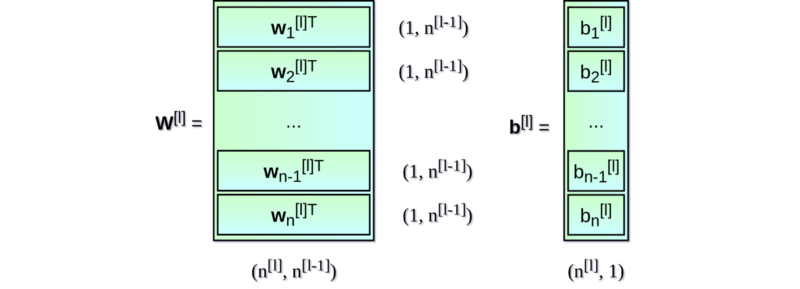
    
<br>
    
<font color=black size=3 face=雅黑>　　其中，**$W$** 和 **$b$** 分别表示权重矩阵和偏置向量。上标 [$l$] 表示当前层的索引，下标 $n$ 表示给定层中的神经元数量。当前层 **$W$** 的形状为 $(n^{[l]},n^{[l-1]})$，**$b$** 的形状为 $(n^{[l]},1)$。
    
<font color=black size=3 face=雅黑>　　请同学们注意区分上图中的矩阵、向量和标量：其中，矩阵用粗体大写字母表示，向量用粗体小写字母表示，标量用普通小写字母表示。
    
<br>


#### <font color=black size=3 face=雅黑>4.2 参数初始化方法

<font color=black size=3 face=雅黑>　　在理解上图的基础上，下面我们可以开始逐层初始化权重矩阵和偏置向量。神经网络参数的初始化对于模型的训练很重要，不良的参数初始值会导致梯度传播问题，降低训练速度，甚至导致模型无法收敛；而良好的参数初始值则能够加快收敛速度，并且更可能找到较优解。 

<font color=black size=3 face=雅黑>　　下面，我们将随机赋予一个小数值给权重矩阵 **$W$** 和偏置向量 **$b$** 的各个元素。这里随机赋值是非常有必要的，我们不能使用完全相同的数字（例如 0）来初始化参数值，否则无法打破神经网络的对称性，会使得训练无法顺利进行。可以想见，如果所有权重都取相同值，那么不管输入是什么，隐藏层中的所有单元都会是相同的，那么反向传播算法计算出来的梯度值也是会相同的，参数更新后仍将保持一致。这种情况下，无论我们训练模型多久、网络有多深，都会陷入在初始状态中。将权重随机初始化为小数值是打破网络对称性的一个普遍方法。
    
<font color=black size=3 face=雅黑>　　那么使用较小的初值又是为什么呢？这里我们以 Sigmoid 函数作为例子来说明。请同学们观察下面 Sigmoid 函数及其导函数曲线图（蓝色-sigmoid，橙色-导数）。

<code>
%%html   
<img src = "https://img-blog.csdnimg.cn/20190716205739176.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly95aXNodWloYW5jaGVuZy5ibG9nLmNzZG4ubmV0,size_16,color_FFFFFF,t_70", width=55%>
    
<font color=black size=3 face=雅黑>　　可以看到，Sigmoid 导函数取值范围在(0,0.25]之间，当输入值较大时，Sigmoid 导数值趋近于0，这可能会导致权重的更新量很小，对神经网络的训练速度造成影响。所有参数使用较小的随机数是一个简单的初始化方法，它保证了我们下面将要进行的模型训练有一个足够好的起点。当然，也不是数值越小就会表现的越好。如果一个神经网络层的所有权重都非常小，那么在反向传播过程中得到的梯度值也将非常小，对于比较深的神经网络来讲，可能会导致“梯度消失”的问题。


#### <font color=black size=3 face=雅黑>4.3 尝试不同的参数初始化方法

<font color=black size=3 face=雅黑>　　同学们稍后请修改下面“init_layer”函数对应的代码，做如下尝试，看看训练结果和上面的有什么不同。 
    
<font color=black size=3 face=雅黑>　　　- 将所有参数初始化为 0
    
<br>

In [5]:
def init_layers(nn_architecture, seed = 99):
    # random seed initiation
    np.random.seed(seed)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage initiation
    params_values = {}

    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # note: we number network layers from 1
        layer_idx = idx + 1

        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]

        
        # initiating the values of the W matrix and vector b for subsequent layers        

        ###############  Please finish this part  ################
        
        # [Hint]: 
        # Think about the size of W & b, and replace 'XXX' with 'layer_input_size' or 'layer_output_size' 
        # in the following code
        #    params_values['W' + str(layer_idx)] = np.random.randn(XXX, XXX) * 0.1
        #    params_values['b' + str(layer_idx)] = np.random.randn(XXX, 1) * 0.1
        
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
        # Have a try: if initialize W & b as 0
        # params_values['W' + str(layer_idx)] = np.zeros((layer_output_size, layer_input_size))
        # params_values['b' + str(layer_idx)] = np.zeros((layer_output_size, 1))
    
        ########################  end  ###########################

    return params_values

<br />

### 5. 实现激活函数

<font color=black size=3 face=雅黑>　　激活函数虽然简单，只需一行代码就可定义，但对神经网络来说非常重要。没有激活函数的话，神经网络将变成线性函数的组合，大大降低了其表达能力。激活函数有很多种。在本次试验中，我们将选用如下两种激活函数：
    
<font color=black size=3 face=雅黑>　　　　－　Sigmoid 函数
    
<font color=black size=3 face=雅黑>　　　　－　ReLU 函数

<br />

<font color=black size=3 face=雅黑>　　接下来我们需要分别实现它们的正向传播（forward）和反向传播（backward）运算。Sigmoid 及 ReLU 的函数曲线和导函数曲线分别如下图中所示。请同学们阅读如下代码，并在留白处根据提示（见[Hint]）填写相应的代码，实现 ReLU 函数的正传和反传过程。

<br />

<code>
%%html   
<img src = "https://pic3.zhimg.com/v2-a658865c292b86272dd141074d902936_b.webp", width=80%>

In [6]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

    
def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)


def relu(Z):
    
    ###############  Please finish this part  ################
    
    # [Hint]: use the following numpy function 
    #    np.maximum(XXX, XXX)
    
    return np.maximum(0,Z)

    ########################  end  ###########################


def relu_backward(dA, Z):
    
    dZ = np.array(dA, copy = True)
    
    ###############  Please finish this part  ################
    
    # [Hint]: use one-line code to mask some entries in dZ to 0
    #     dZ[XXX] = 0
    
    dZ [Z <= 0] = 0
    
    ########################  end  ###########################
    
    return dZ

<br />

### 6. 实现神经网络的前向传播过程

<font color=black size=3 face=雅黑>　　对整个神经网络来说，输入矩阵 $X$ 传入网络后将逐层向前传播，并最终在网络末端得到输出向量 $Y\_hat$。为了让代码更易读，接下来我们将把前向传播过程拆分成两个函数来实现：

<font color=black size=3 face=雅黑>　　－　函数 6-1 (single_layer_forward_propagation)： 实现单个全连接层的前向传播过程

<font color=black size=3 face=雅黑>　　－　函数 6-2 (full_forward_propagation)： 基于函数 6-1，实现整个全连接神经网络的前向传播过程

<br />

#### <font color=black size=3 face=雅黑>6.1　函数 6-1 （single_layer_forward_propagation）：实现单个全连接层的前向传播过程

<br>
    
<font color=black size=3 face=雅黑>　　相对于反向传播来讲，神经网络层的前向传播过程是比较直观、容易理解的。这里我们假设来自上一层的输入信号为 $A\_prev$，当前层的权重矩阵和偏置向量分别为 $W\_curr$ 和 $b\_curr$。首先，我们需要实现 $W\_curr$ 和 $A\_prev$ 之间的矩阵乘法运算，并将结果与 $b\_curr$ 相加，得到 $Z\_curr$。这一部分运算我们将通过 Numpy 完成。基于 NumPy，我们可以对整个网络层和整批样本一次性进行矩阵操作，无需迭代，这大大简化了我们的代码，也加速了计算。

<font color=black size=3 face=雅黑>　　这个运算过程如下图所示，请注意理解每个矩阵和向量的维度：
    
<code>
%%html
<img src = "https://pic2.zhimg.com/v2-b999ab8463b39b4d83a3c8b34ba24d61_r.jpg", width=80%>
    

<font color=black size=3 face=雅黑>　　接着，我们需要对矩阵运算结果应用所选的激活函数（参数'activation'），由 $Z\_curr$ 得到 $A\_curr$。
    
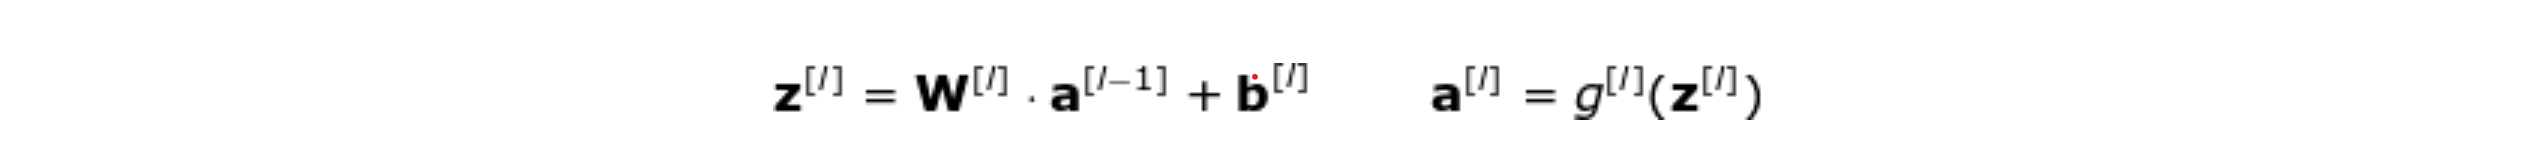
    
<font color=black size=3 face=雅黑>　　函数的输出除了经过激活函数处理的最终结果 $A\_curr$ 外，还包含中间结果 $Z\_curr$，这是因为我们将在反向传播时用到这些中间数据。
    
<br>

In [7]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):

    # calculation of the input value for the activation function

    ###############  Please finish this part  ################
    
    # [Hint]: 
    # - please implement the computation between W_curr, b_curr, and A_prev
    # - you will need to use the numpy function  ->  np.dot(XXX,XXX)
    # - the code will be like:   Z_curr = XXX
    Z_curr = np.dot(W_curr, A_prev) + b_curr

    ########################  end  ###########################

    # selection of activation function
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')

    # return of calculated activation A and the intermediate Z matrix
    return activation_func(Z_curr), Z_curr


#### <font color=black size=3 face=雅黑>6.2　函数 6-2 (full_forward_propagation)： 基于函数 6-1，实现整个神经网络的前向传播过程

<br>
    
<font color=black size=3 face=雅黑>　　在实现了单个全连接层的前向传播后，下一步就是实现整个神经网络的前向传播。神经网络的输入记为 $X$。除了 $X$，函数还需要网络结构的信息（nn_architecture）及初始化好的网络参数（函数 init_layers 的输出 params_values）。
    
<font color=black size=3 face=雅黑>　　需要特别注意的是，我们必须在逐层迭代时保存好反向传播需要的一些中间值，即各层的 $A\_prev$ 和 $Z\_curr$。这里我们将用一个 dictionary ('memory'）来保存这些中间值。
   
<font color=black size=3 face=雅黑>　　函数的输出除了神经网络的最终输出 '$A\_curr$' (即 $y\_hat$)外，还有保存有中间值的变量 '$memory$'。
    
<br>

In [8]:
def full_forward_propagation(X, params_values, nn_architecture):
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X  # shape of X: (2,900)

    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr

        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]

        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        # extraction of b for the current layer
        b_curr = params_values["b" + str(layer_idx)]

        # calculation of activation for the current layer
        
        ###############  Please finish this part  ################
        
        # [Hint]: invoke the function single_layer_forward_propagation
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)

        ########################  end  ###########################

        # saving calculated values in the memory
        
        ###############  Please finish this part  ################
        
        # [Hint]: 
        #   memory["A" + str(idx)] = XXX  (A_prev or A_curr ???)
        #   memory["Z" + str(layer_idx)] = XXX
        
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr        
        
        ########################  end  ###########################

    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, memory


<br />

### 7. 损失函数

<br>

<font color=black size=3 face=雅黑>　　损失函数可以监测训练进展，确保我们向着正确的方向移动。“一般来说，损失函数显示了我们与'理想'解决方案之间的距离。”损失函数包含很多种（例如 Pytorch 中提供了很多选项，可见其官方网站 https://pytorch.org/docs/stable/nn.html#loss-functions
    )，我们通常需要根据具体问题来选择。 

<font color=black size=3 face=雅黑>　　我们计划将神经网络应用于二元分类问题，即模型最后的预测结果只有两种情况，对于每个类别我们预测得到的概率将分别为 $p$ 和 $1-p$。在这个问题中我们将使用交叉熵损失函数 (cross entropy loss)：

<br>
    
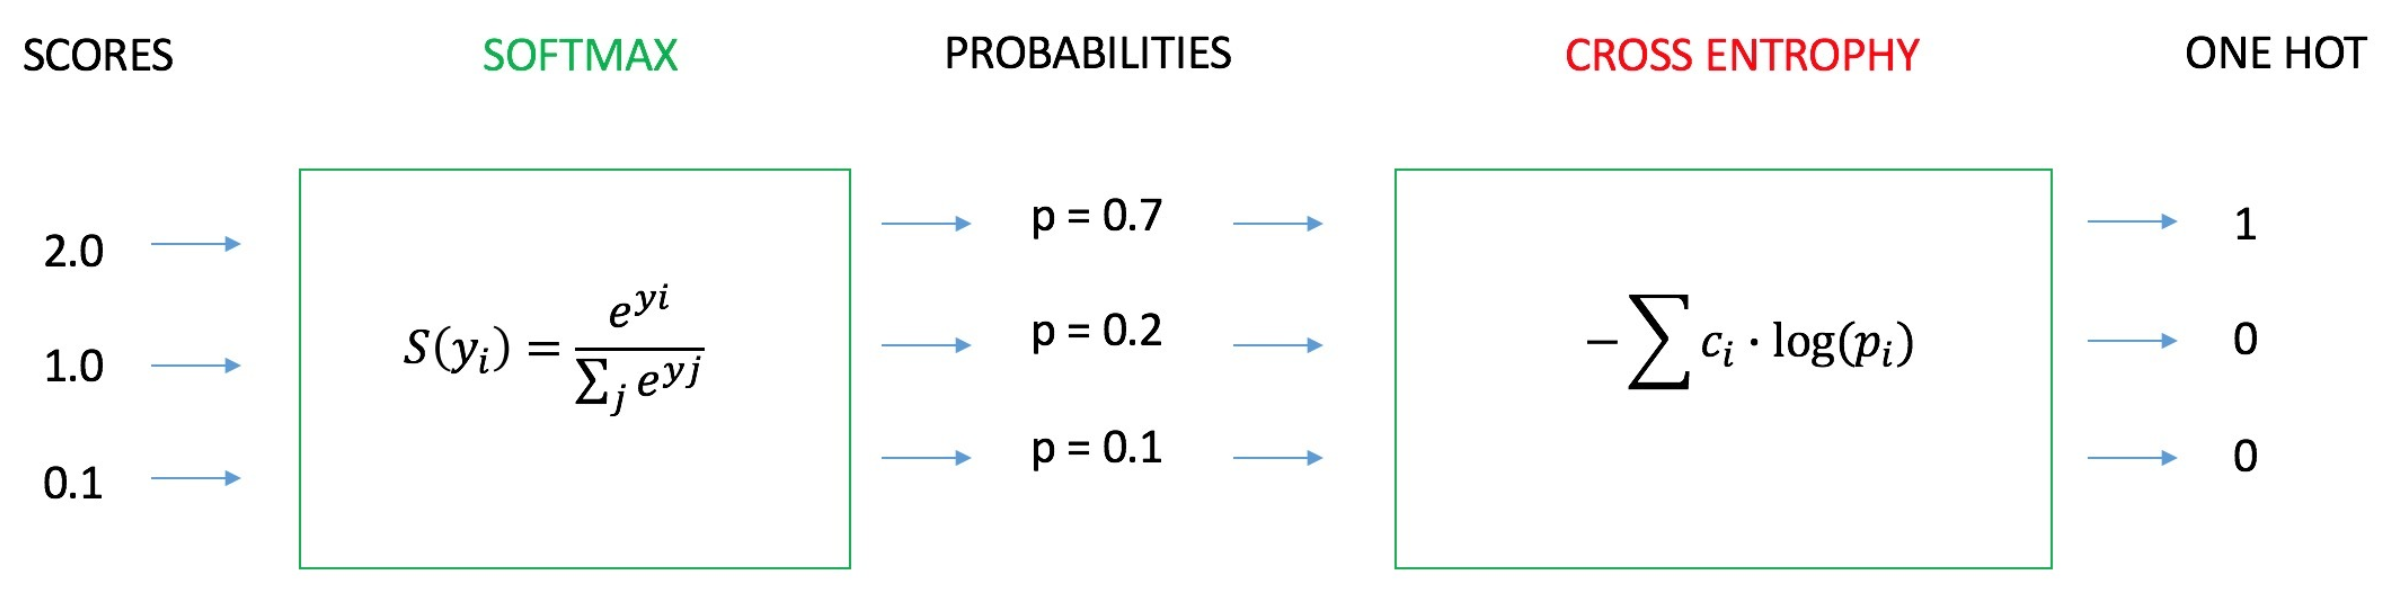

<br>
 


<font color=black size=3 face=雅黑>　　对于二元分类问题，其交叉熵损失函数写作：

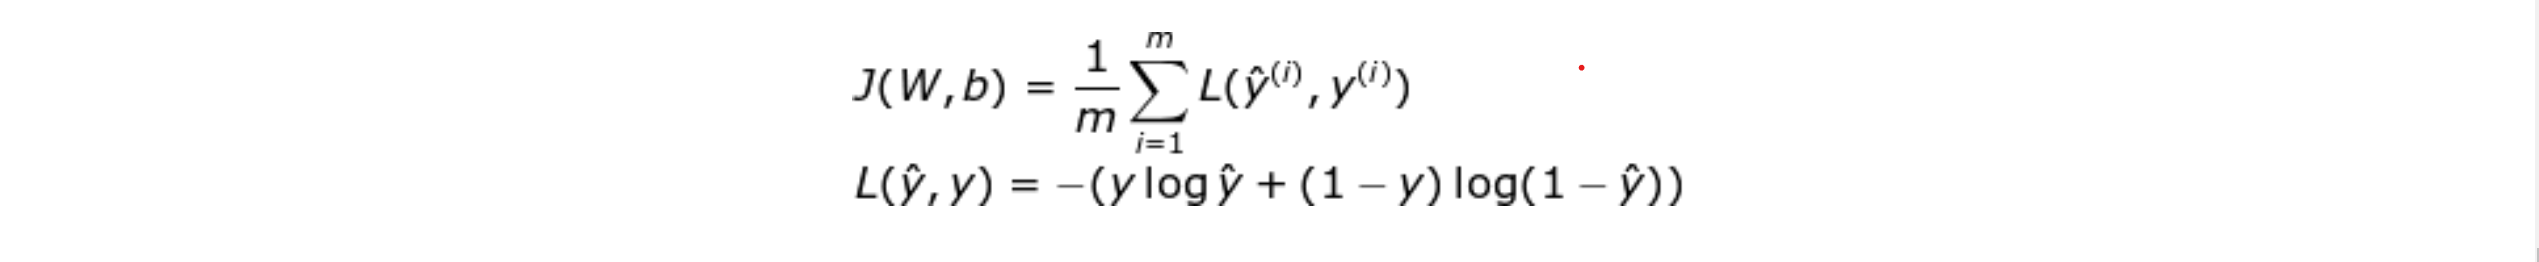

In [9]:
def get_cost_value(Y_hat, Y):
    # number of examples (=900)
    m = Y_hat.shape[1]
    # calculation of the cost according to the formula
    # - Y: each element is either 0 or 1
    # - shape of Y & Y_hat: (1,900)
    # - shape of cost: (1,1)
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    
    return np.squeeze(cost)  # np.squeeze() -  从数组的形状中删除单维条目，即把shape中为1的维度去掉

<br>

<font color=black size=3 face=雅黑>　　为了取得更多关于学习过程的信息，我们还可以另外实现一个计算精确度的函数。
    
<br>

In [10]:
# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)  # shape: (1,900)
    accuracy = (Y_hat_ == Y).all(axis=0).mean()  # numpy.all(): 测试沿给定轴的所有数组元素是否都计算为True
                                                 # (Y_hat_ == Y).all(axis=0).shape = (900,)
                                                 # numpy.mean(): 求取均值
    return accuracy

<br />

### 8. 实现神经网络的反向传播过程

<br>

    
<font color=black size=3 face=雅黑>　　和前向传播一样，我们将把网络的反向传播过程拆分成两个函数来实现：

<font color=black size=3 face=雅黑>　　　　－　函数 8-1 (single_layer_backward_propagation)： 实现单个全连接层的反向传播过程

<font color=black size=3 face=雅黑>　　　　－　函数 8-2 (full_backward_propagation)： 基于函数 8-1，实现整个神经网络的反向传播过程

<br >  

#### <font color=black size=3 face=雅黑>8.1　函数 8-1 (single_layer_backward_propagation)： 实现单个全连接层的反向传播过程

<br>

<font color=black size=3 face=雅黑>　　下图显示了单个神经元上的前向传播和反向传播过程。对一个神经网络层 ($l$)，我们将接收传输自 $l+1$ 层的 $dA^{[l]}$，并根据前向传播时保存在 $memory$ 的中间数据 $Z\_curr$ 和 $A\_prev$，计算 $loss$ 对权重 $𝑊^{[𝑙]}$和偏置 $𝑏^{[𝑙]}$的偏导数——$d𝑊^{[𝑙]}$ 和 $d𝑏^{[𝑙]}$。

<code>
%%html
<img src = "https://pic3.zhimg.com/v2-ffb7dc9760f74bc720f2745eda6d777e_r.jpg", width=70%>


<font color=black size=3 face=雅黑>　　下面的公式描述了单个全连接层上的反向传播过程。由于本次实验的重点在于实际实现，所以此处省略求导过程，感兴趣的同学请阅读课本相关章节。从公式上我们可以很明显地看到，为什么之前需要在前向传播时记住中间层的 $A\_prev$ 和 $Z\$_curr$ 矩阵的值。

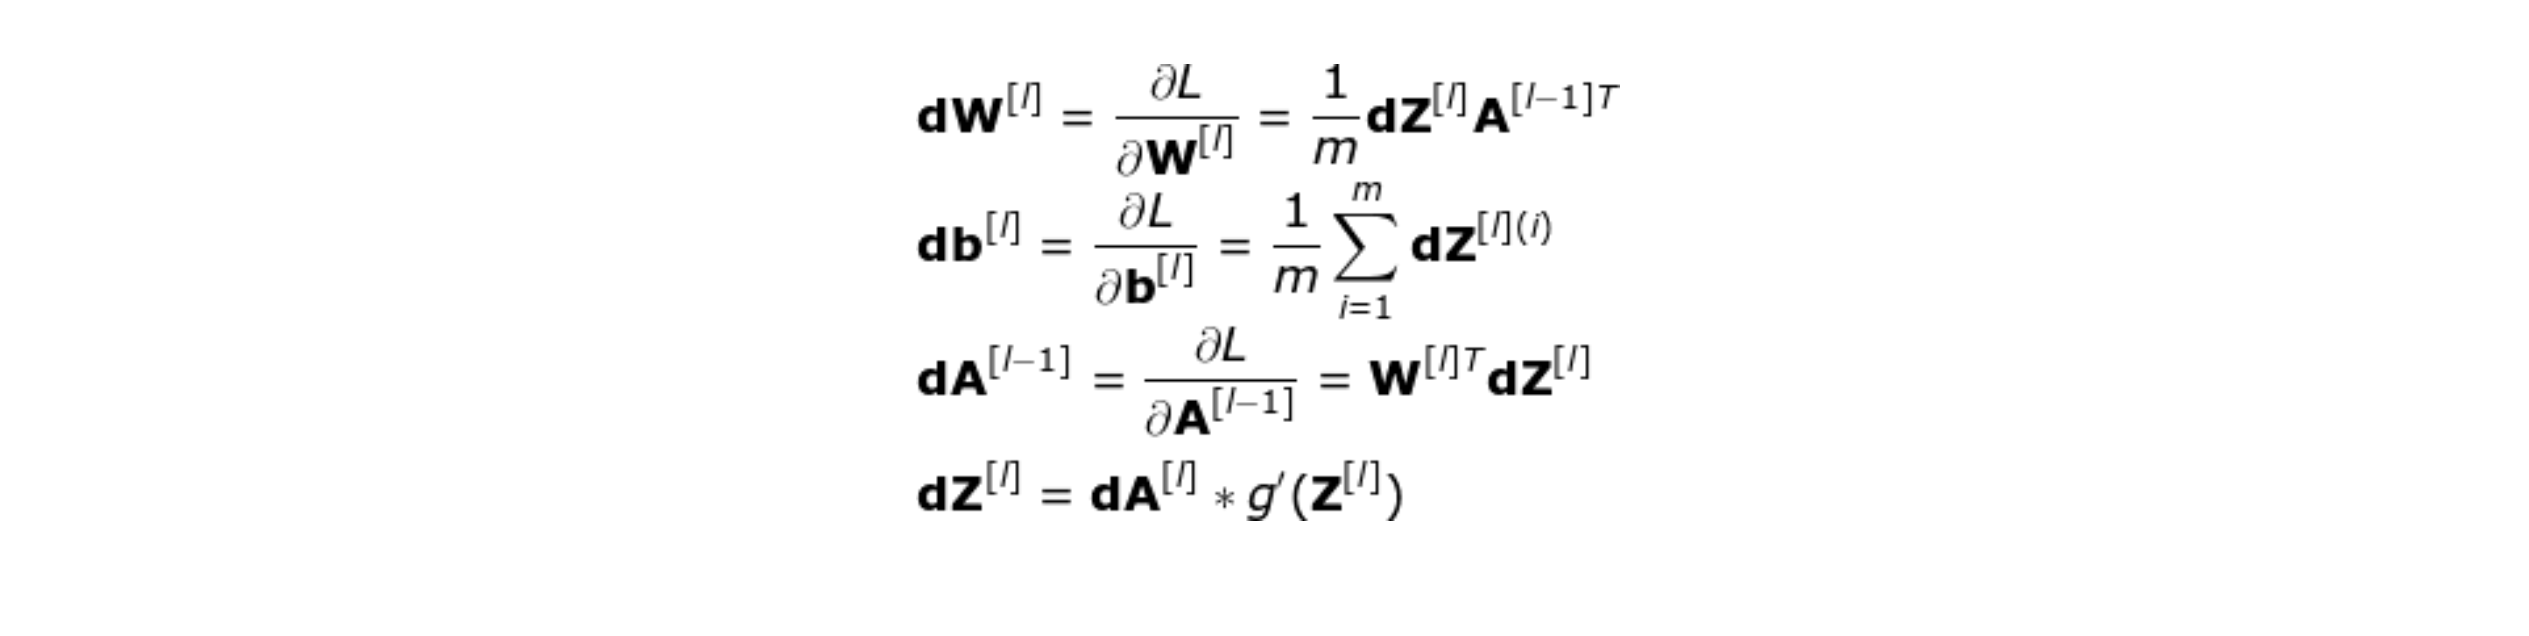

In [11]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # number of examples
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')

    # step-1: {dA_curr, Z_curr} -> dZ_curr (activation function derivative)
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    
    # step-2: {dZ_curr, A_prev} -> dW_curr (derivative of the matrix W)
    #         dZ_curr -> db_curr (derivative of the vector b)
    
    ###############  Please finish this part  ################
    
    # [Hint]: get dW_curr and db_curr from dZ_curr and A_prev
    #   dW_curr = np.dot(XXX，XXX) / m
    
    dW_curr = np.dot(dZ_curr, A_prev.T) / m

    ########################  end  ###########################
    
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m  # np.sum(): sum of array elements over a given axis
    # or, you can write it as:
    # db_curr = np.dot(dZ_curr, np.ones((dZ_curr.shape[1], 1))) / m  # dZ_curr.shape[1] = 900
    
    
    # step-3: {dZ_curr, W_curr} -> dA_prev (derivative of the matrix A_prev)
    
    ###############  Please finish this part  ################

    # [Hint]: get dA_prev from dZ_curr and W_curr
    #   dA_prev = np.dot(XXX，XXX)
    
    dA_prev = np.dot(W_curr.T, dZ_curr)
    
    ########################  end  ###########################

    return dA_prev, dW_curr, db_curr

<br>

#### <font color=black size=3 face=雅黑>8.2　函数 8-2 (full_backward_propagation)： 实现整个神经网络的反向传播过程

<br>
    
<font color=black size=3 face=雅黑>　　基于单个网络层的反向传播函数，我们从最后一层开始迭代计算所有参数上的导数（$dW$ 和 $db$），并最终返回包含所需梯度的字典。为了计算各层参数上的导数，函数需要输入前向传播时的网络输出 $Y\_hat$ 和标准结果 $Y$，并交由损失函数计算 $loss$。$loss$ 对于 $Y\_hat$ 的偏导数可计算如下：
    
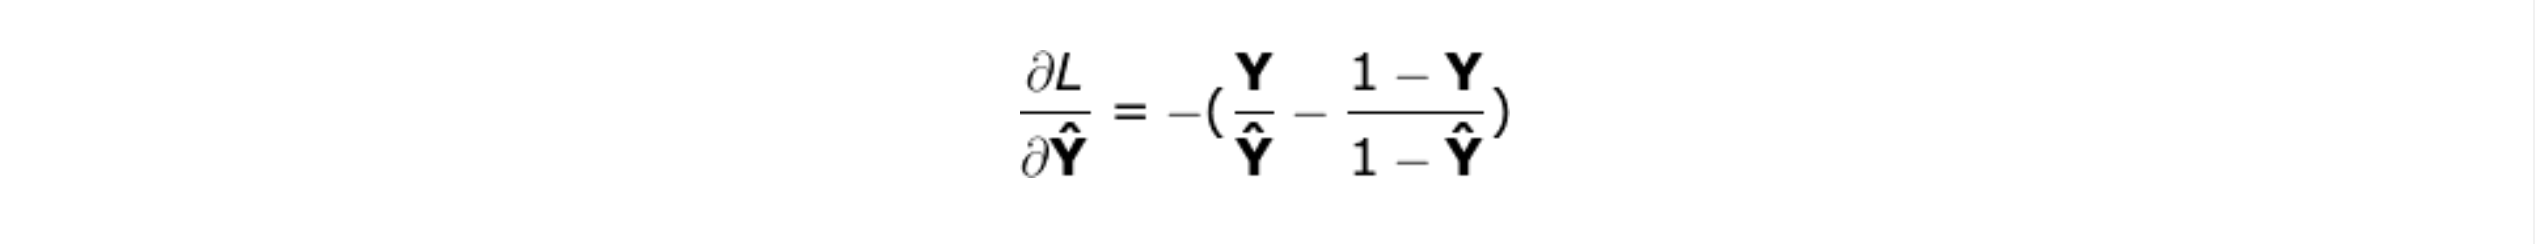
    
<font color=black size=3 face=雅黑>　　此外，函数还需要输入如下信息：

<font color=black size=3 face=雅黑>　　　　- 前向传播时的中间数据 $memory$ (含 $A\_prev$ 和 $Z\_curr$) —— 用以计算各层的 $dW$ 和 $db$；

<font color=black size=3 face=雅黑>　　　　- 神经网络的参数 $params\_values$ —— 用以计算各层的 $dA\_prev$。
    
<br>
    
<font color=black size=3 face=雅黑>　　函数的输出是各层的 $dW$ 和 $db$，保存在 $grads\_values$ 中。
    
<br>

<font color=black size=3 face=雅黑>　　在编写函数8-2前，我们先来试验一下等下将怎样从最后一层开始，向前逐层处理网络：

In [12]:
# let's see how we will access each layer in the backward pass
for layer_idx_prev, layer in reversed(list(enumerate(NN_ARCHITECTURE))):  # we will use this code line in the function 8-2
    print(layer_idx_prev)  # from 4 to 0
    print(layer)  # from layer L to layer 1 (we number network layers from 1)

4
{'input_dim': 25, 'output_dim': 1, 'activation': 'sigmoid'}
3
{'input_dim': 50, 'output_dim': 25, 'activation': 'relu'}
2
{'input_dim': 50, 'output_dim': 50, 'activation': 'relu'}
1
{'input_dim': 25, 'output_dim': 50, 'activation': 'relu'}
0
{'input_dim': 2, 'output_dim': 25, 'activation': 'relu'}


In [13]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    # number of examples (Y.shape=(1,900))
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

<br />

### 9. 更新参数值

<br>

    
<font color=black size=3 face=雅黑>　　反向传播是为了计算梯度，以根据梯度进行优化，更新网络的参数值。为了完成这一任务，我们将使用如下两组数据：
    
<font color=black size=3 face=雅黑>　　　- $params\_values$，其中保存了当前参数值；
    
<font color=black size=3 face=雅黑>　　　- $grads\_values$，其中保存了用于更新参数值所需的梯度信息。

<br>   
    
<font color=black size=3 face=雅黑>　　接下来我们只需在每个网络层上应用以下公式即可。其中，$\alpha$ 指学习率 (learning rate)。
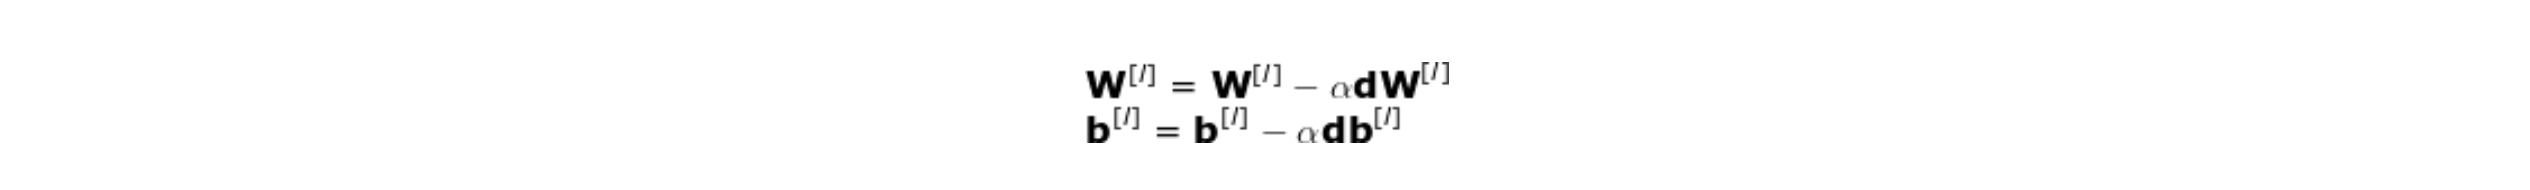

In [14]:
def update(params_values, grads_values, nn_architecture, learning_rate):
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        
        ###############  Please finish this part  ################
        
        # [Hint]: update params_values
        #   params_values["W" + str(layer_idx)] = XXX
        #   params_values["b" + str(layer_idx)] = XXX

        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]
        
        ########################  end  ###########################

    return params_values


<br />

### 10. 整合：完成 train 函数

<br>

    
<font color=black size=3 face=雅黑>　　到目前为止，我们已经完成了最困难的部分，准备好了所需的函数，接下来只需以正确的顺序把它们整合到一起。为了更好地理解每一步操作的顺序，请同学们再次查看“0. 概览”中的训练流程图。
    
<font color=black size=3 face=雅黑>　　train 函数将返回经过训练优化后的参数值，并显示在训练期间模型在训练集上的准确率。后期在测试集上，只需使用训练好的模型参数并运行一次完整的前向传播过程即可。

<br>

In [15]:
def train(X, Y, nn_architecture, epochs, learning_rate, verbose=True, callback=None):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        # step forward
        Y_hat, cache = full_forward_propagation(X, params_values, nn_architecture)
        
        if i==1:
            print("X.shape: ", X.shape)  # (2, 900)
            print("Y_hat.shape: ", Y_hat.shape)  # (1, 900)
            print("Y.shape: ", Y.shape)  # (1, 900)
        
        # calculating metrics and saving them in history
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        # step backward - calculating gradient
        grads_values = full_backward_propagation(Y_hat, Y, cache, params_values, nn_architecture)
        # updating model state
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if(i % 50 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values


### 11. 数据集准备

<br>

    
<font color=black size=3 face=雅黑>　　现在是时候尝试应用我们的模型来解决一个简单的分类问题。为了检测模型是否能够顺利训练，下面我们将生成一个含有两个类的点集（如下图所示，两个类别的点分别用不同颜色表示），然后尝试训练模型来对这些点进行分类（二元分类问题）。

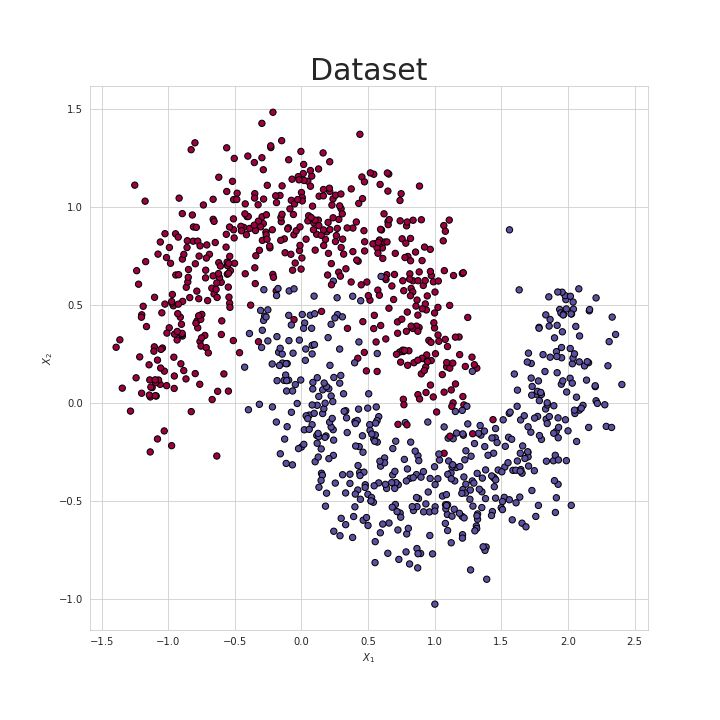

In [16]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1

In [17]:
# we will use sklearn.make_moons() to generate the dataset:
#  - n_samples: 生成样本数量
#  - noise: 高斯噪声
#  - random_state: 生成随机种子，给定一个int型数据，能够保证每次生成数据相同
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)

# split the dataset into training set (90%) & test set (10%)
#  - test_size: 如果是浮点数，则应该在0.0和1.0之间，表示要测试集占总数据集的比例；如果是int类型，表示测试集的绝对数量。
#  - random_state: 随机数生成器使用的种子
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

<br>

<font color=black size=3 face=雅黑>　　下面我们来观察一下刚刚生成好的数据集。
    
<br>

In [18]:
# check the information in X
print("shape of X: ", X.shape)  # (1000,2)
print("X = ", X)

# check the information in X_train
print("shape of X: ", X_train.shape)

shape of X:  (1000, 2)
X =  [[ 2.24907069e-05  1.07275825e+00]
 [-5.59037377e-02  4.25241282e-01]
 [ 2.40944879e-02  4.08065802e-01]
 ...
 [ 1.75841594e+00 -5.77404262e-01]
 [ 1.26710180e+00 -4.42980152e-01]
 [-1.75927072e-01  5.83509936e-01]]
shape of X:  (900, 2)


In [19]:
# check the information in Y
print("shape of Y: ", y.shape)  # (1000,)
print("number of zeros in Y: ", np.sum(y==0))  # 500
print("number of ones in Y: ", np.sum(y==1))  # 500
print("Y = ", y)

shape of Y:  (1000,)
number of zeros in Y:  500
number of ones in Y:  500
Y =  [0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 1
 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0
 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0
 0 0 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0
 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1
 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0
 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1
 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 1 1 0 1 0 0
 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 0 0 1 0 1 1
 0 0 1 0 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 0
 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0
 1 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0
 1 1 1 0 1 1 1 1 1 0 

In [20]:
# the function making up the graph of a dataset
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()

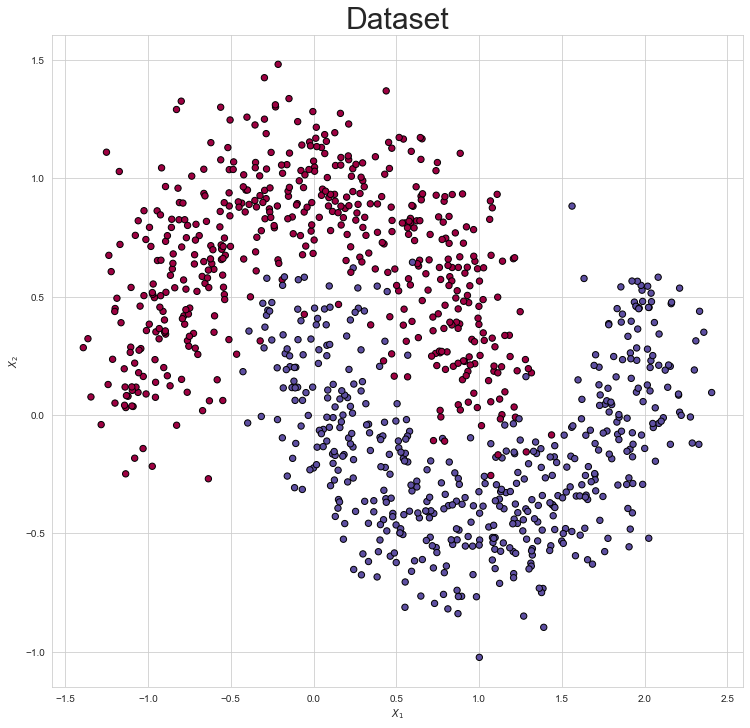

In [21]:
# plot the dataset
make_plot(X, y, "Dataset")

<br>

<font color=black size=3 face=雅黑>　　请同学们依次尝试将 sklearn.make_moons() 函数中 noise 取 0, 0.2, 0.4, 0.8, 1.0 等不同值，查看并截图保存对应的数据集图像和训练结果，分析其趋势，及出现这样趋势的原因。
    
<font color=black size=3 face=雅黑>　　然后，请同学们将 sklearn.make_moons() 中 noise 固定为 0.8，将sklearn.model_selection.train_test_split() 函数中的 TEST_SIZE 改为 0.98，观察和原先 noise 为 0.2、TEST_SIZE 为 0.1 的情况相比，训练集上的准确度和测试集上的准确度都分别发生了什么变化？出现这样变化的原因是什么？
    
<br>

<br>

### 12. 模型训练及测试

<br>

    
<font color=black size=3 face=雅黑>　　下面我们来调用 train 函数对模型进行训练。
    
<br>

In [22]:
# let's train the neural network
params_values = train(X=np.transpose(X_train), Y=np.transpose(y_train.reshape((y_train.shape[0], 1))), 
                      nn_architecture=NN_ARCHITECTURE, epochs=10000, learning_rate=0.01)

Iteration: 00000 - cost: 0.69365 - accuracy: 0.50444
X.shape:  (2, 900)
Y_hat.shape:  (1, 900)
Y.shape:  (1, 900)
Iteration: 00050 - cost: 0.69349 - accuracy: 0.50444
Iteration: 00100 - cost: 0.69334 - accuracy: 0.50444
Iteration: 00150 - cost: 0.69319 - accuracy: 0.50444
Iteration: 00200 - cost: 0.69307 - accuracy: 0.50444
Iteration: 00250 - cost: 0.69295 - accuracy: 0.50444
Iteration: 00300 - cost: 0.69284 - accuracy: 0.50444
Iteration: 00350 - cost: 0.69272 - accuracy: 0.50444
Iteration: 00400 - cost: 0.69260 - accuracy: 0.50444
Iteration: 00450 - cost: 0.69249 - accuracy: 0.50444
Iteration: 00500 - cost: 0.69238 - accuracy: 0.50444
Iteration: 00550 - cost: 0.69228 - accuracy: 0.50444
Iteration: 00600 - cost: 0.69217 - accuracy: 0.50444
Iteration: 00650 - cost: 0.69206 - accuracy: 0.50444
Iteration: 00700 - cost: 0.69194 - accuracy: 0.50444
Iteration: 00750 - cost: 0.69182 - accuracy: 0.50444
Iteration: 00800 - cost: 0.69170 - accuracy: 0.50444
Iteration: 00850 - cost: 0.69156 - acc

Iteration: 07750 - cost: 0.08707 - accuracy: 0.96667
Iteration: 07800 - cost: 0.08647 - accuracy: 0.96778
Iteration: 07850 - cost: 0.08594 - accuracy: 0.96667
Iteration: 07900 - cost: 0.08544 - accuracy: 0.96667
Iteration: 07950 - cost: 0.08497 - accuracy: 0.96667
Iteration: 08000 - cost: 0.08453 - accuracy: 0.96556
Iteration: 08050 - cost: 0.08412 - accuracy: 0.96667
Iteration: 08100 - cost: 0.08371 - accuracy: 0.96667
Iteration: 08150 - cost: 0.08332 - accuracy: 0.96889
Iteration: 08200 - cost: 0.08295 - accuracy: 0.96889
Iteration: 08250 - cost: 0.08259 - accuracy: 0.96889
Iteration: 08300 - cost: 0.08219 - accuracy: 0.96889
Iteration: 08350 - cost: 0.08180 - accuracy: 0.96778
Iteration: 08400 - cost: 0.08145 - accuracy: 0.96778
Iteration: 08450 - cost: 0.08114 - accuracy: 0.96778
Iteration: 08500 - cost: 0.08084 - accuracy: 0.96889
Iteration: 08550 - cost: 0.08055 - accuracy: 0.96889
Iteration: 08600 - cost: 0.08025 - accuracy: 0.97000
Iteration: 08650 - cost: 0.07996 - accuracy: 0

<br>

<font color=black size=3 face=雅黑>　　调用一次 full_forward_propagation()，在测试集上评估训练好的模型。

<br>

In [23]:
# prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [24]:
# accuracy achieved on the test set
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f}".format(acc_test))

Test set accuracy: 0.98


<br>

<font color=black size=3 face=雅黑>　　请同学们将 learning_rate 分别改为 0.1 和 0.001，观察训练过程中的 cost 和 accuracy 变化趋势，并分析其原因。

<br>

<br>
<br>

## 实验报告

<br>

<font color=black size=3 face=雅黑> 1. 填补以上代码中的空缺，并逐条说明原因。
    
<font color=black size=3 face=雅黑> 2. 运行完成后的代码，并保存训练和测试结果。

<font color=black size=3 face=雅黑> 3. 参考第6.1节的图，画出第二层和第三层网络在前向传播和反向传播时的矩阵运算：请用大小合适的矩形代表矩阵和向量，并标明每个矩阵和向量的维度。
    
<font color=black size=3 face=雅黑> 4. 参考第3节，尝试不同的网络结构，看看训练结果是否有什么不同，分析其趋势及原因。
    
<font color=black size=3 face=雅黑> 5. 参考第4.3节，尝试不同的参数初始化方法，将网络参数全部初始化为0，观察训练结果并分析原因。
    
<font color=black size=3 face=雅黑> 6. 参考第11节内容，调整 make_moons() 函数中的 noise 和 train_test_split() 函数中的 TEST_SIZE，改变数据集中点的分布，按照11节中的说明完成分析。
    
<font color=black size=3 face=雅黑> 7. 参考第12节内容，请将 learning_rate 分别改为 0.1 和 0.001，观察训练过程中的 cost 和 accuracy 变化趋势，并分析其原因。
    
<br>
<br>